# RL Assignment 3 : Problem 2

Name : Ahmik Virani <br>
Roll Number : ES22BTECH11001

In [19]:
import gymnasium as gym
import ale_py
import cv2
import numpy as np
import pygame
import random
from collections import deque
import matplotlib.pyplot as plt
gym.register_envs(ale_py)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim

### Q3 (a)

In [20]:
# An agent which takes random actions at each state
def run_random_agent(env, render):
    # We keep track of the reward
    total_reward = 0
    
    # A variable which keeps track of weather the episode is over or not
    done = False
    while not done:
        # Take a random action
        action = env.action_space.sample()
        next_observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        if(render):
            env.render()
        total_reward += reward
    
    # Return the reward for this episode
    return total_reward

# A function which loads the environment
# Prints the necessary points asked in the question
# And runs the random agent
def load_and_test_env(env_name, n_episodes=5, render=False):
    print(f"Loading environment: {env_name}")
    if(render):
        env = gym.make(env_name, render_mode="human")
    else:
        env = gym.make(env_name)

    state_space = env.observation_space
    action_space = env.action_space
    print()
    print("State Space: ", state_space)
    print("Size of State Space", state_space.shape[0])
    print()
    print("Action Space: ", action_space)
    print("Size of Action space: ", action_space.n)
    print()

    for episode in range(n_episodes):
        observation, info = env.reset()
        reward = run_random_agent(env, render)
        print(f"Episode #{episode+1}: reward = {reward}")

In [21]:
load_and_test_env("LunarLander-v3")

Loading environment: LunarLander-v3

State Space:  Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Size of State Space 8

Action Space:  Discrete(4)
Size of Action space:  4

Episode #1: reward = -253.16053919925412
Episode #2: reward = -98.35948459985701
Episode #3: reward = -172.89284106932644
Episode #4: reward = -124.88564766262155
Episode #5: reward = -81.76856242481237


## Q3 (b)

In [40]:
# Declare global variables
learning_rate = 0.01
gamma = 0.99

N = 100     # Number of iterations of the Policy Gradient Algorithm
K = 32      # Batch Size
render = False

In [41]:
# We will use a simple single hidden layer neural network
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(PolicyNetwork, self).__init__()

        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        output = torch.softmax(self.fc2(x), dim=-1)
        return output

In [42]:
class REINFORCE():
    def __init__(self, state_dim, action_dim, reward_to_go, advantage_normalization, hidden_dim=128):
        # We will use the above neural network for the policy
        self.policy = PolicyNetwork(state_dim, action_dim, hidden_dim)

        # We use adam optimizer
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)

        # We need to do some book keeping for rewards and log probabilities
        self.episode_rewards = []
        self.episode_log_probs = []

        # Boolean values, if we need reward to go and advantage normalization
        self.reward_to_go = reward_to_go
        self.advantage_normalization = advantage_normalization

    # Finds the probability for action given the state
    def select_action(self, state, testing = False):
        state = torch.tensor(np.asarray(state, dtype=np.float32).flatten()).unsqueeze(0)
        # We get the probability distribution of actions over the states
        probs = self.policy(state)
        # We sample actions acording to the given probabilities
        distributions = torch.distributions.Categorical(probs)
        action = distributions.sample()
        # Need to store the log probability for policy gradient step
        if not testing:
            log_prob = distributions.log_prob(action)
            self.episode_log_probs.append(log_prob)
        return action.item()

    # Function to get the policy gradient value
    def get_policy_grad(self):
        # We need the rewards G_t for each time step of the episode
        discounted_rewards = []
        cumulative_reward = 0

        # If reward to go, then at each time step, we have to compute the reward as r_t + gamma * r_{t-1}
        if(self.reward_to_go):
            for reward in reversed(self.episode_rewards):
                cumulative_reward = reward + gamma * cumulative_reward
                discounted_rewards.insert(0, cumulative_reward)
        # If not reward to go, each time step gets the same G_{0:infinity}
        else:
            for reward in reversed(self.episode_rewards):
                cumulative_reward = reward + gamma * cumulative_reward
            discounted_rewards = [cumulative_reward] * len(self.episode_rewards)
        
        discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32)

        # If we do advantage normalization, I use mean baseline and then normalize
        if(self.advantage_normalization):
            discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)

        # Compute the policy loss
        loss=0
        for log_prob, reward in zip(self.episode_log_probs, discounted_rewards):
            loss += -log_prob * reward

        # Reset the episode rewards before going to the next episode
        self.episode_rewards = []
        self.episode_log_probs = []
        
        return loss

    # Perform the gradient descent step
    def update_policy(self, average_loss):
        self.optimizer.zero_grad()
        average_loss.backward()
        self.optimizer.step()

In [43]:
# Training curves
def plot_rewards(rewards, window=50):
    plt.figure(figsize=(10, 5))
    
    # Plot raw rewards
    plt.plot(rewards, label='Episode Reward', color='lightgray', alpha=0.7)
    
    # Compute moving average
    if len(rewards) >= window:
        moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
        plt.plot(range(window - 1, len(rewards)), moving_avg,
                 label=f'Moving Average (window={window})', color='blue', linewidth=2)
    
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Progress at each episode')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.show()

def plot_test_rewards(rewards):
    plt.figure(figsize=(10,5))
    plt.plot(rewards, label='Average Episode Reward')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Average reward on 100 tests after each iteration')
    plt.title('Training Progress at each iteration')
    plt.legend()
    plt.show()

### LunarLander

In [44]:
rewards_with_different_settings = []

No reward to go, No Advantage Normalization

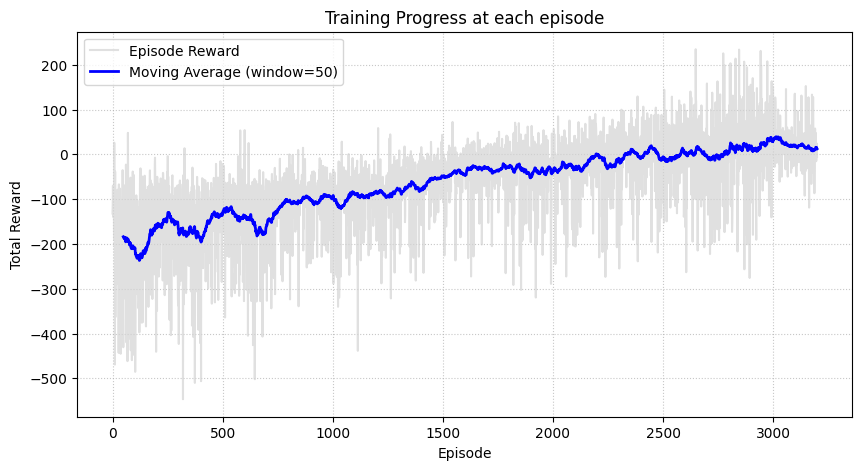

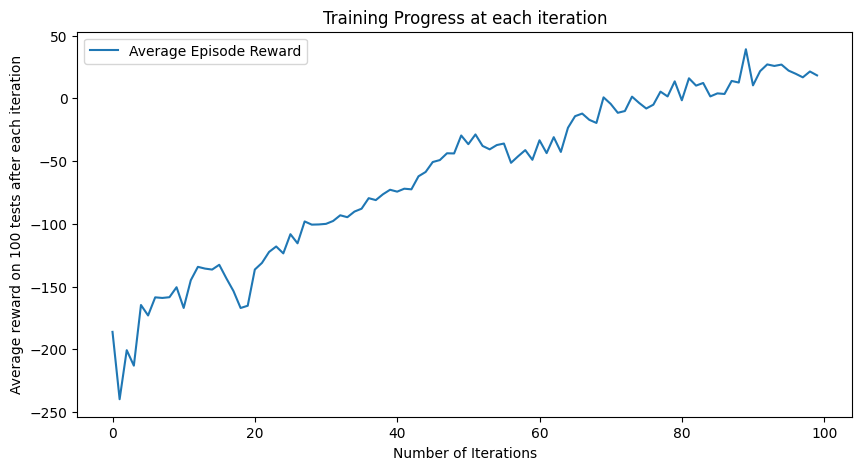

In [45]:
# This is the training loop as per the lecture slides (pg.pdf)
# Algorithm Vanilla Policy Gradient Algorithm
env = gym.make('LunarLander-v3')
agent = REINFORCE(env.observation_space.shape[0], env.action_space.n, False, False)
episode_rewards = []

test_episode_rewards = []

for n in range(N):
    total_loss = 0

    # Sample K trajectories by executing the policy
    for episode in range(K):

        state, _ = env.reset()
        total_reward = 0
        done = False
        # All the sampling is done as per the current policy
        while not done:
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = (terminated or truncated)
            agent.episode_rewards.append(reward)
            total_reward += reward
            state = next_state
        episode_rewards.append(total_reward)
        total_loss += agent.get_policy_grad()
    average_loss = total_loss / K
    # We update the policy depending on the sample loss
    agent.update_policy(average_loss)

    # Let us test for some episodes
    total_test_reward = 0
    for test_episode in range(100):
        state, _ = env.reset()
        done = False
        while not done:
            action = agent.select_action(state, True)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = (terminated or truncated)
            total_test_reward += reward
            state = next_state
    # Append average reward per 100 episodes
    test_episode_rewards.append(total_test_reward/100)

plot_rewards(episode_rewards)
plot_test_rewards(test_episode_rewards)
rewards_with_different_settings.append(test_episode_rewards)
env.close()

Reward to go, No Advantage Normalization

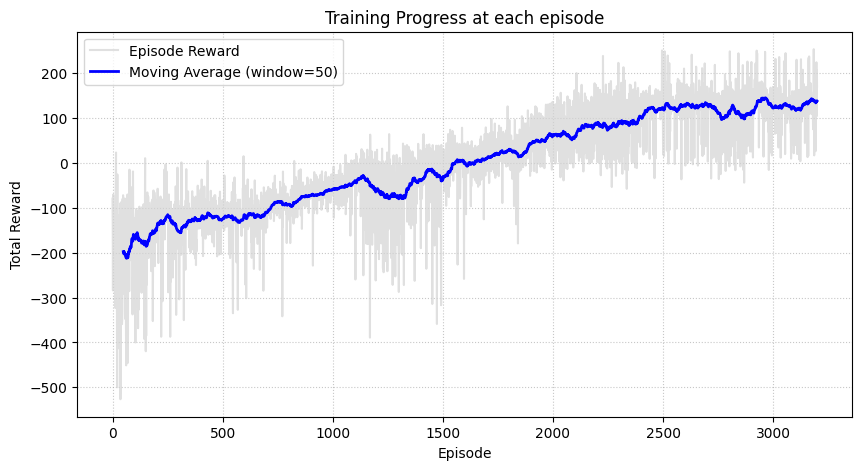

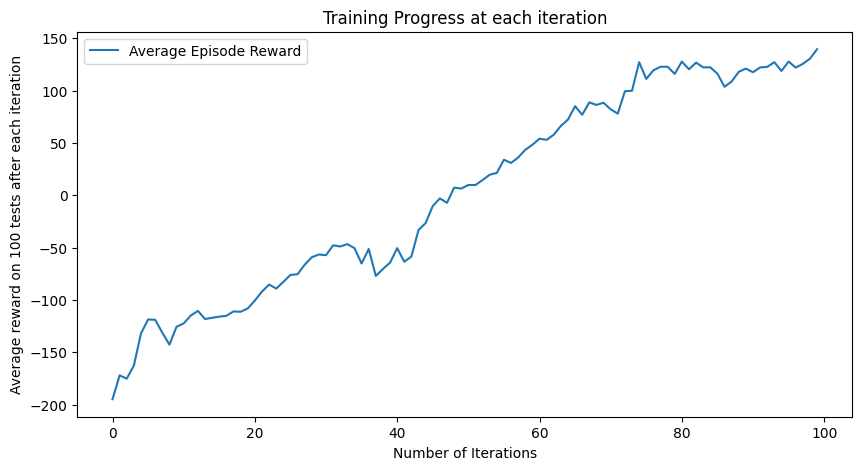

In [46]:
# This is the training loop as per the lecture slides (pg.pdf)
# Algorithm Vanilla Policy Gradient Algorithm
env = gym.make('LunarLander-v3')
agent = REINFORCE(env.observation_space.shape[0], env.action_space.n, True, False)
episode_rewards = []

test_episode_rewards = []

for n in range(N):
    total_loss = 0

    # Sample K trajectories by executing the policy
    for episode in range(K):

        state, _ = env.reset()
        total_reward = 0
        done = False
        # All the sampling is done as per the current policy
        while not done:
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = (terminated or truncated)
            agent.episode_rewards.append(reward)
            total_reward += reward
            state = next_state
        episode_rewards.append(total_reward)
        total_loss += agent.get_policy_grad()
    average_loss = total_loss / K
    # We update the policy depending on the sample loss
    agent.update_policy(average_loss)

    # Let us test for some episodes
    total_test_reward = 0
    for test_episode in range(100):
        state, _ = env.reset()
        done = False
        while not done:
            action = agent.select_action(state, True)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = (terminated or truncated)
            total_test_reward += reward
            state = next_state
    # Append average reward per 100 episodes
    test_episode_rewards.append(total_test_reward/100)

plot_rewards(episode_rewards)
plot_test_rewards(test_episode_rewards)
rewards_with_different_settings.append(test_episode_rewards)
env.close()

No reward to go, Advantage Normalization

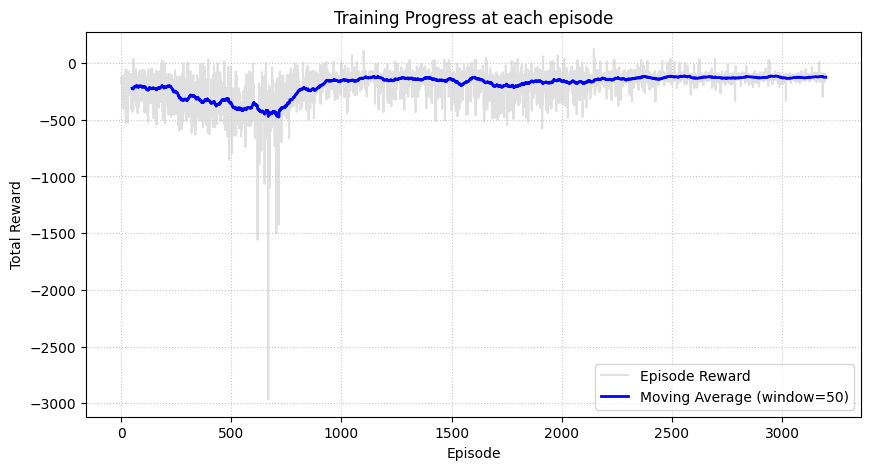

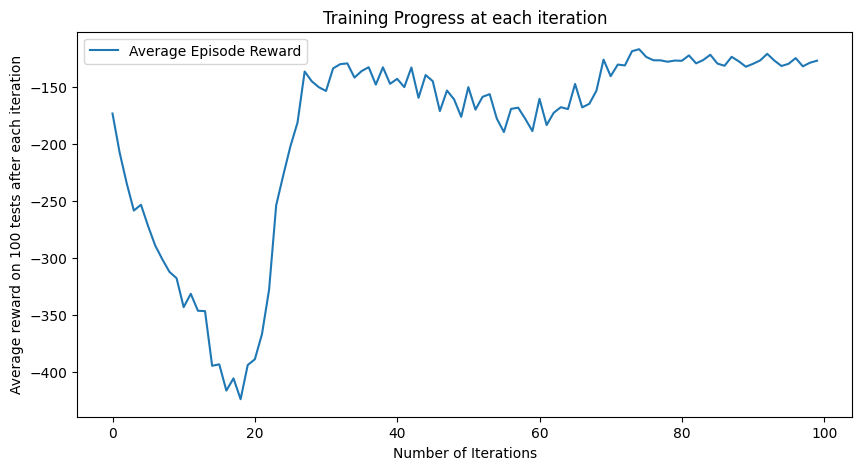

In [47]:
# This is the training loop as per the lecture slides (pg.pdf)
# Algorithm Vanilla Policy Gradient Algorithm
env = gym.make('LunarLander-v3')
agent = REINFORCE(env.observation_space.shape[0], env.action_space.n, False, True)
episode_rewards = []

test_episode_rewards = []

for n in range(N):
    total_loss = 0

    # Sample K trajectories by executing the policy
    for episode in range(K):

        state, _ = env.reset()
        total_reward = 0
        done = False
        # All the sampling is done as per the current policy
        while not done:
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = (terminated or truncated)
            agent.episode_rewards.append(reward)
            total_reward += reward
            state = next_state
        episode_rewards.append(total_reward)
        total_loss += agent.get_policy_grad()
    average_loss = total_loss / K
    # We update the policy depending on the sample loss
    agent.update_policy(average_loss)

    # Let us test for some episodes
    total_test_reward = 0
    for test_episode in range(100):
        state, _ = env.reset()
        done = False
        while not done:
            action = agent.select_action(state, True)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = (terminated or truncated)
            total_test_reward += reward
            state = next_state
    # Append average reward per 100 episodes
    test_episode_rewards.append(total_test_reward/100)

plot_rewards(episode_rewards)
plot_test_rewards(test_episode_rewards)
rewards_with_different_settings.append(test_episode_rewards)
env.close()

Reward to go, Advantage Normalization

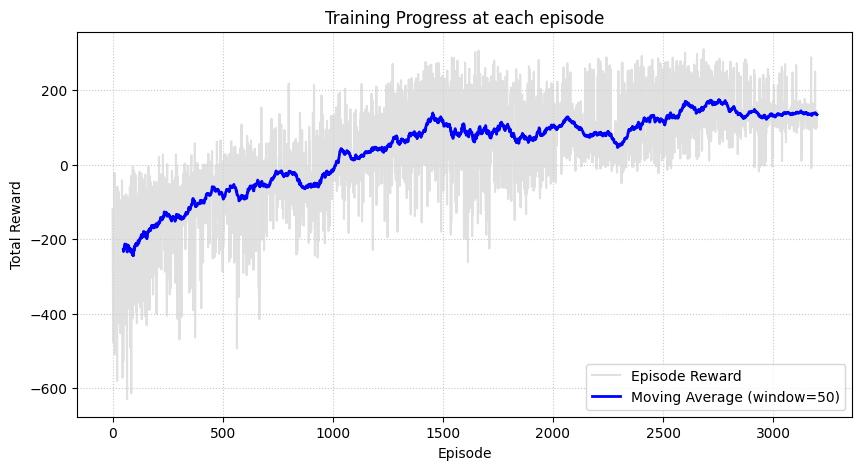

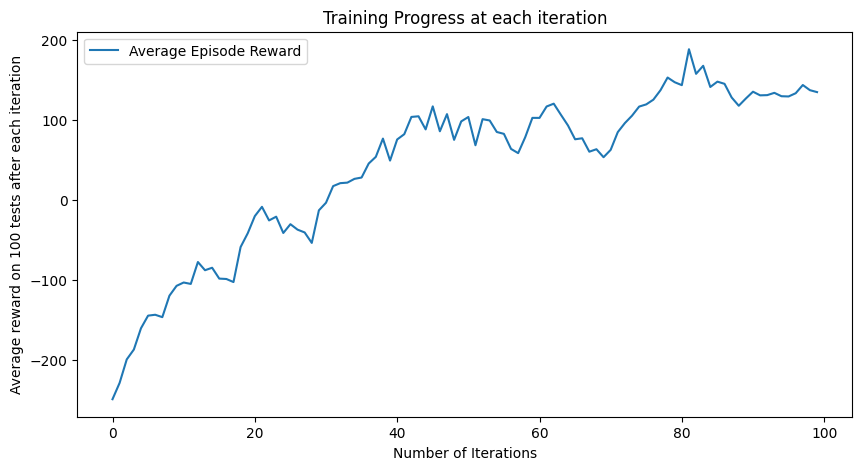

In [48]:
# This is the training loop as per the lecture slides (pg.pdf)
# Algorithm Vanilla Policy Gradient Algorithm
env = gym.make('LunarLander-v3')
agent = REINFORCE(env.observation_space.shape[0], env.action_space.n, True, True)
episode_rewards = []

test_episode_rewards = []

for n in range(N):
    total_loss = 0

    # Sample K trajectories by executing the policy
    for episode in range(K):

        state, _ = env.reset()
        total_reward = 0
        done = False
        # All the sampling is done as per the current policy
        while not done:
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = (terminated or truncated)
            agent.episode_rewards.append(reward)
            total_reward += reward
            state = next_state
        episode_rewards.append(total_reward)
        total_loss += agent.get_policy_grad()
    average_loss = total_loss / K
    # We update the policy depending on the sample loss
    agent.update_policy(average_loss)

    # Let us test for some episodes
    total_test_reward = 0
    for test_episode in range(100):
        state, _ = env.reset()
        done = False
        while not done:
            action = agent.select_action(state, True)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = (terminated or truncated)
            total_test_reward += reward
            state = next_state
    # Append average reward per 100 episodes
    test_episode_rewards.append(total_test_reward/100)

plot_rewards(episode_rewards)
plot_test_rewards(test_episode_rewards)
rewards_with_different_settings.append(test_episode_rewards)
env.close()

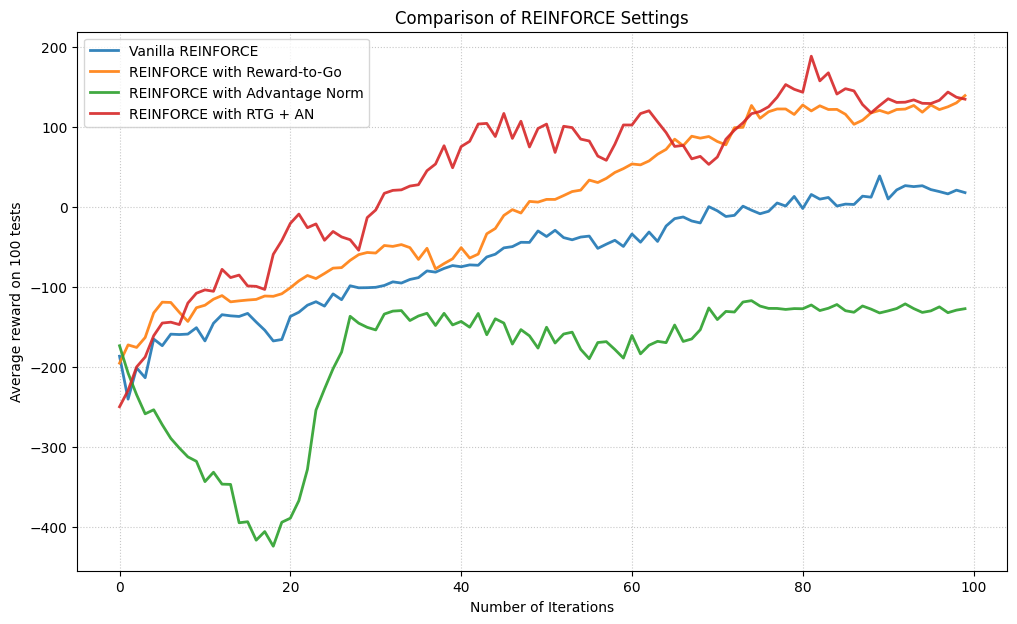

In [ ]:
# Labels for each line in the plot
# RTG = Reward to go
# AN = Advantage Normalization
experiment_labels = [
    'Vanilla REINFORCE',
    'REINFORCE with Reward-to-Go',
    'REINFORCE with Advantage Norm',
    'REINFORCE with RTG + AN'
]

plt.figure(figsize=(12, 7))

# Loop through each experiment reward list and plot it
for rewards, label in zip(rewards_with_different_settings, experiment_labels):
    plt.plot(rewards, label=label, linewidth=2, alpha=0.9)

plt.xlabel('Number of Iterations')
plt.ylabel('Average reward on 100 tests')
plt.title('Comparison of REINFORCE Settings')

plt.legend()

plt.grid(True, linestyle=':', alpha=0.7)

plt.show()

## Q3 (c)

In [ ]:
def plot_per_batch_size(rewards_per_batch_size, batch_sizes):

    plt.figure(figsize=(12, 7))

    # Loop through each experiment reward list and plot it
    for rewards, batch_size in zip(rewards_per_batch_size, batch_sizes):
        label = f'Batch Size = {batch_size}'
        plt.plot(rewards, label=label, linewidth=2, alpha=0.9)

    plt.xlabel('Number of Iterations')
    plt.ylabel('Average reward on 100 tests')
    plt.title('Comparison of Batch Size')

    plt.legend()

    plt.grid(True, linestyle=':', alpha=0.7)

    plt.show()

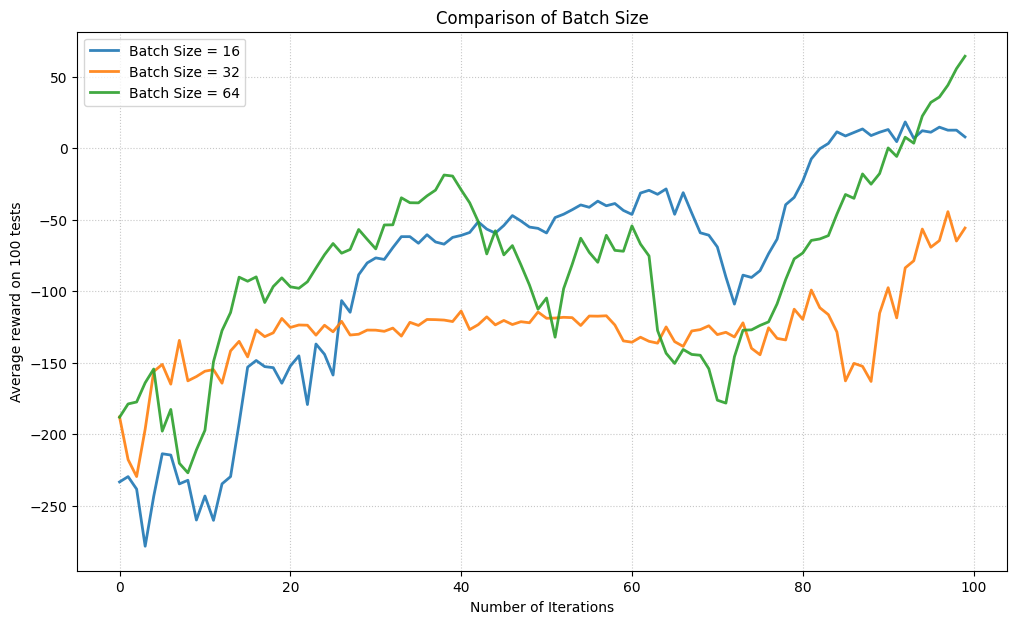

In [51]:
batch_sizes = [16, 32, 64]

rewards_per_batch_size = []
for K in batch_sizes: 
    env = gym.make('LunarLander-v3')
    agent = REINFORCE(env.observation_space.shape[0], env.action_space.n, False, False)
    episode_rewards = []

    test_episode_rewards = []

    for n in range(N):
        total_loss = 0

        # Sample K trajectories by executing the policy
        for episode in range(K):

            state, _ = env.reset()
            total_reward = 0
            done = False
            # All the sampling is done as per the current policy
            while not done:
                action = agent.select_action(state)
                next_state, reward, terminated, truncated, info = env.step(action)
                done = (terminated or truncated)
                agent.episode_rewards.append(reward)
                total_reward += reward
                state = next_state
            episode_rewards.append(total_reward)
            total_loss += agent.get_policy_grad()
        average_loss = total_loss / K
        # We update the policy depending on the sample loss
        agent.update_policy(average_loss)

        # Let us test for some episodes
        total_test_reward = 0
        for test_episode in range(100):
            state, _ = env.reset()
            done = False
            while not done:
                action = agent.select_action(state, True)
                next_state, reward, terminated, truncated, info = env.step(action)
                done = (terminated or truncated)
                total_test_reward += reward
                state = next_state
        # Append average reward per 100 episodes
        test_episode_rewards.append(total_test_reward/100)

    rewards_per_batch_size.append(test_episode_rewards)
    env.close()
plot_per_batch_size(rewards_per_batch_size, batch_sizes)

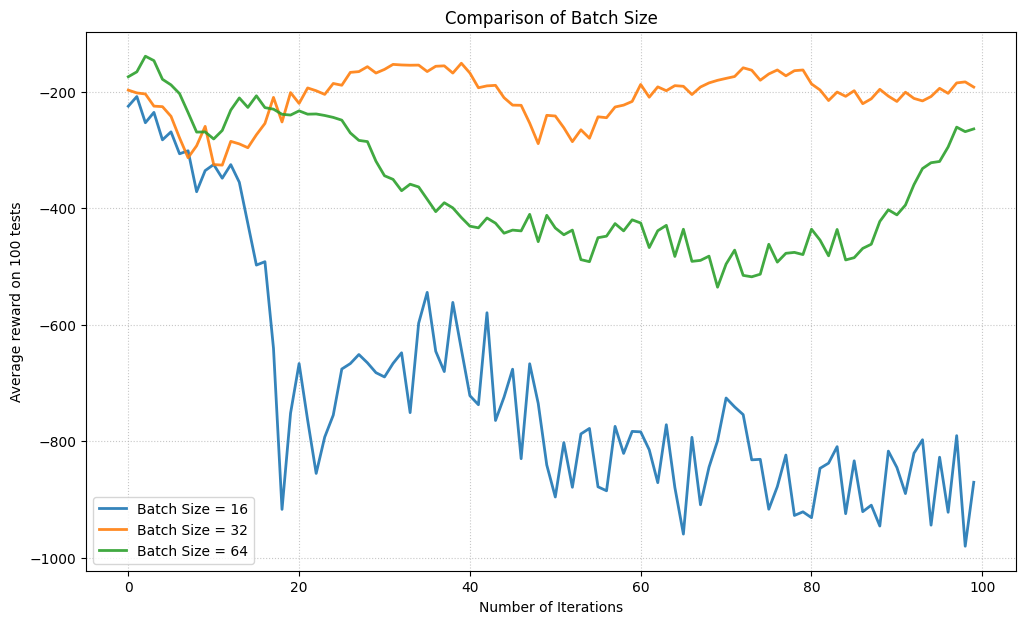

In [52]:
batch_sizes = [16, 32, 64]

rewards_per_batch_size = []
for K in batch_sizes: 
    env = gym.make('LunarLander-v3')
    agent = REINFORCE(env.observation_space.shape[0], env.action_space.n, False, True)
    episode_rewards = []

    test_episode_rewards = []

    for n in range(N):
        total_loss = 0

        # Sample K trajectories by executing the policy
        for episode in range(K):

            state, _ = env.reset()
            total_reward = 0
            done = False
            # All the sampling is done as per the current policy
            while not done:
                action = agent.select_action(state)
                next_state, reward, terminated, truncated, info = env.step(action)
                done = (terminated or truncated)
                agent.episode_rewards.append(reward)
                total_reward += reward
                state = next_state
            episode_rewards.append(total_reward)
            total_loss += agent.get_policy_grad()
        average_loss = total_loss / K
        # We update the policy depending on the sample loss
        agent.update_policy(average_loss)

        # Let us test for some episodes
        total_test_reward = 0
        for test_episode in range(100):
            state, _ = env.reset()
            done = False
            while not done:
                action = agent.select_action(state, True)
                next_state, reward, terminated, truncated, info = env.step(action)
                done = (terminated or truncated)
                total_test_reward += reward
                state = next_state
        # Append average reward per 100 episodes
        test_episode_rewards.append(total_test_reward/100)

    rewards_per_batch_size.append(test_episode_rewards)
    env.close()
plot_per_batch_size(rewards_per_batch_size, batch_sizes)

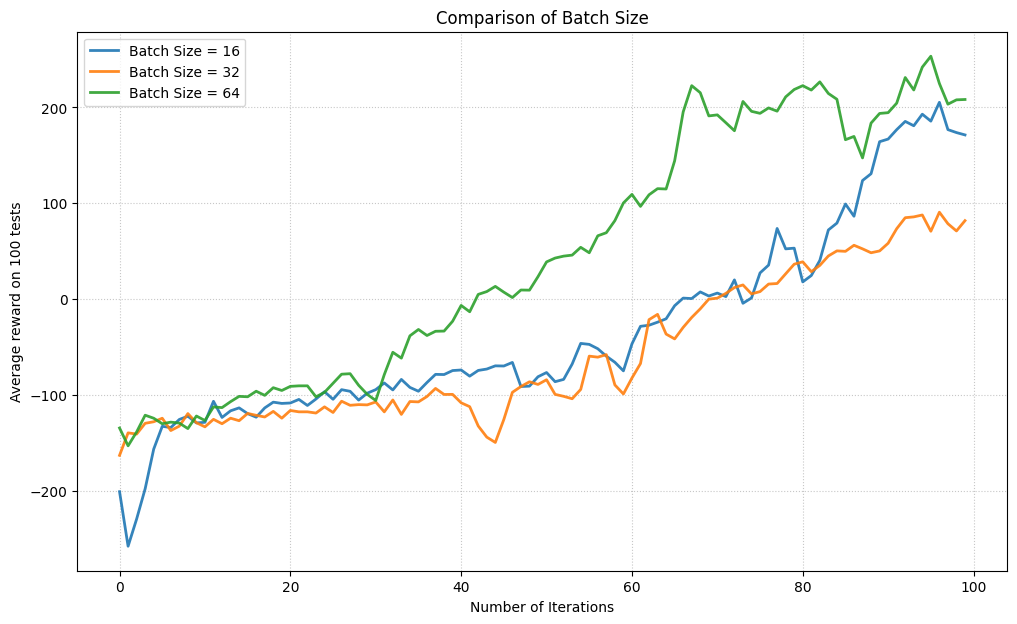

In [53]:
batch_sizes = [16, 32, 64]

rewards_per_batch_size = []
for K in batch_sizes: 
    env = gym.make('LunarLander-v3')
    agent = REINFORCE(env.observation_space.shape[0], env.action_space.n, True, False)
    episode_rewards = []

    test_episode_rewards = []

    for n in range(N):
        total_loss = 0

        # Sample K trajectories by executing the policy
        for episode in range(K):

            state, _ = env.reset()
            total_reward = 0
            done = False
            # All the sampling is done as per the current policy
            while not done:
                action = agent.select_action(state)
                next_state, reward, terminated, truncated, info = env.step(action)
                done = (terminated or truncated)
                agent.episode_rewards.append(reward)
                total_reward += reward
                state = next_state
            episode_rewards.append(total_reward)
            total_loss += agent.get_policy_grad()
        average_loss = total_loss / K
        # We update the policy depending on the sample loss
        agent.update_policy(average_loss)

        # Let us test for some episodes
        total_test_reward = 0
        for test_episode in range(100):
            state, _ = env.reset()
            done = False
            while not done:
                action = agent.select_action(state, True)
                next_state, reward, terminated, truncated, info = env.step(action)
                done = (terminated or truncated)
                total_test_reward += reward
                state = next_state
        # Append average reward per 100 episodes
        test_episode_rewards.append(total_test_reward/100)

    rewards_per_batch_size.append(test_episode_rewards)
    env.close()
plot_per_batch_size(rewards_per_batch_size, batch_sizes)

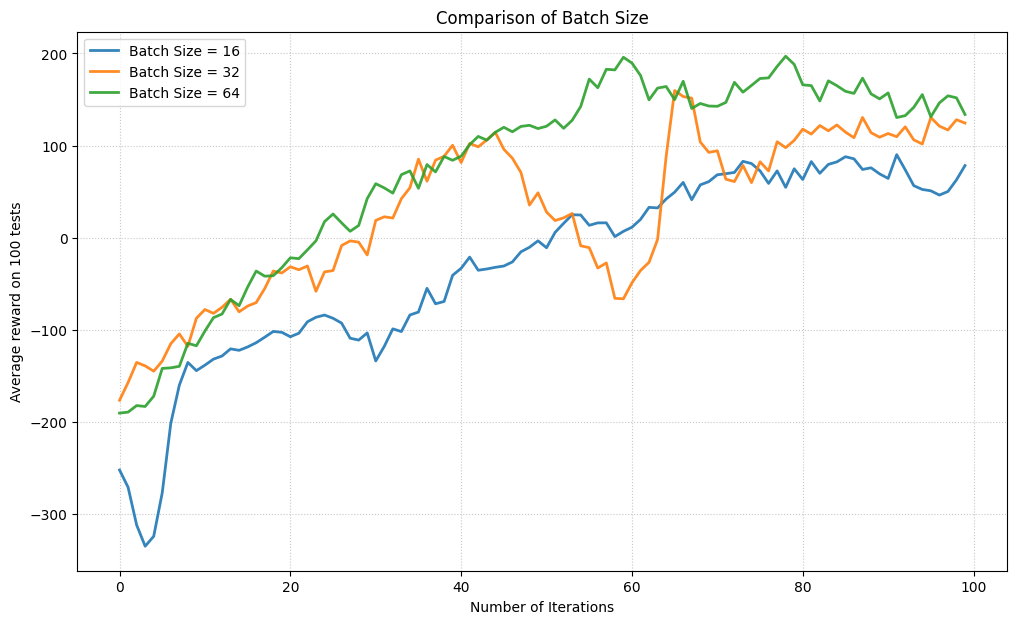

In [54]:
batch_sizes = [16, 32, 64]

rewards_per_batch_size = []
for K in batch_sizes: 
    env = gym.make('LunarLander-v3')
    agent = REINFORCE(env.observation_space.shape[0], env.action_space.n, True, True)
    episode_rewards = []

    test_episode_rewards = []

    for n in range(N):
        total_loss = 0

        # Sample K trajectories by executing the policy
        for episode in range(K):

            state, _ = env.reset()
            total_reward = 0
            done = False
            # All the sampling is done as per the current policy
            while not done:
                action = agent.select_action(state)
                next_state, reward, terminated, truncated, info = env.step(action)
                done = (terminated or truncated)
                agent.episode_rewards.append(reward)
                total_reward += reward
                state = next_state
            episode_rewards.append(total_reward)
            total_loss += agent.get_policy_grad()
        average_loss = total_loss / K
        # We update the policy depending on the sample loss
        agent.update_policy(average_loss)

        # Let us test for some episodes
        total_test_reward = 0
        for test_episode in range(100):
            state, _ = env.reset()
            done = False
            while not done:
                action = agent.select_action(state, True)
                next_state, reward, terminated, truncated, info = env.step(action)
                done = (terminated or truncated)
                total_test_reward += reward
                state = next_state
        # Append average reward per 100 episodes
        test_episode_rewards.append(total_test_reward/100)

    rewards_per_batch_size.append(test_episode_rewards)
    env.close()
plot_per_batch_size(rewards_per_batch_size, batch_sizes)